In [1]:

from splat.read_colmap import read_images_text, qvec2rotmat
from splat.scene import GaussianScene
import pycolmap
import torch 
import torch.nn as nn
import numpy as np

reconstruction = pycolmap.Reconstruction("/Users/derek/Desktop/colmap/gerrard-hall/sparse/0")

points3d = reconstruction.points3D
images = read_images_text("/Users/derek/Desktop/colmap/gerrard-hall/sparse/images.txt")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []
for point in points3d.values():
    # I would assume this is seeing it from multiple images
    if point.track.length() >= 5:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color / 256)
        
scene = GaussianScene(torch.Tensor(np.array(all_points3d)[:10000]), torch.Tensor(np.array(all_point_colors)))

In [2]:
# project all points to 2d
from splat.utils import get_intrinsic_matrix, get_extrinsic_matrix

image_num = 14

fx, fy, cx, cy = cameras[1].params[:4]
intrinsic_homogeneous = get_intrinsic_matrix(fx, fy, cx, cy)
image_qvec = images[image_num].qvec
image_tvec = images[image_num].tvec
# normalize the qvec
# image_qvec = image_qvec / np.linalg.norm(image_qvec)
image_rotation_matrix = qvec2rotmat(image_qvec)
image_translation = torch.Tensor(image_tvec)
extrinsic_matrix = get_extrinsic_matrix(image_rotation_matrix, image_translation)

points, z, covariances = scene.get_points_and_covariance(extrinsic_matrix=extrinsic_matrix, intrinsic_matrix=intrinsic_homogeneous)

In [3]:
covariances

tensor([[[ 782.2245,   99.8242],
         [  99.8242,  602.5770]],

        [[7099.2739, -536.1555],
         [-536.1555, 5643.7432]],

        [[ 445.1354,   58.2010],
         [  58.2010,  342.7206]],

        ...,

        [[1967.9679,  130.8376],
         [ 130.8376, 1661.1034]],

        [[1886.1122,  139.9867],
         [ 139.9867, 1589.6194]],

        [[2658.3203,  190.9201],
         [ 190.9201, 2215.4553]]], grad_fn=<StackBackward0>)

In [3]:
camera_coord_points = torch.concatenate([points, z], dim=1)
three_dim_cov = scene.get_3d_covariance_matrix()
three_dim_cov

tensor([[[0.0100, 0.0000, 0.0000],
         [0.0000, 0.0100, 0.0000],
         [0.0000, 0.0000, 0.0100]],

        [[0.0100, 0.0000, 0.0000],
         [0.0000, 0.0100, 0.0000],
         [0.0000, 0.0000, 0.0100]],

        [[0.0100, 0.0000, 0.0000],
         [0.0000, 0.0100, 0.0000],
         [0.0000, 0.0000, 0.0100]],

        [[0.0100, 0.0000, 0.0000],
         [0.0000, 0.0100, 0.0000],
         [0.0000, 0.0000, 0.0100]],

        [[0.0100, 0.0000, 0.0000],
         [0.0000, 0.0100, 0.0000],
         [0.0000, 0.0000, 0.0100]]], grad_fn=<UnsafeViewBackward0>)

In [4]:
intrinsic_matrix = intrinsic_homogeneous

fx = intrinsic_matrix[0, 0]
fy = fx
W = extrinsic_matrix[:3, :3].transpose(0, 1)
camera_coords_x = camera_coord_points[:, 0] / camera_coord_points[:, 2]
camera_coords_y = camera_coord_points[:, 1] / camera_coord_points[:, 2]
camera_coords_z = camera_coord_points[:, 2]

jacobian = torch.zeros((3, 3))
jacobian[0, 0] = (fx.item() / camera_coords_z)[0]
jacobian[1, 1] = (fy.item() / camera_coords_z)[0]
jacobian[0, 2] = -(fx.item() * camera_coords_x / (camera_coords_z ** 2))[0]
jacobian[1, 2] = (fy.item() * camera_coords_y / (camera_coords_z ** 2))[0]

variance = jacobian @ W @ three_dim_cov @ W.T @ jacobian.T
variance

tensor([[[ 1.1425e+10, -6.4468e+09,  0.0000e+00],
         [-6.4468e+09,  3.6376e+09,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.1425e+10, -6.4468e+09,  0.0000e+00],
         [-6.4468e+09,  3.6376e+09,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.1425e+10, -6.4468e+09,  0.0000e+00],
         [-6.4468e+09,  3.6376e+09,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.1425e+10, -6.4468e+09,  0.0000e+00],
         [-6.4468e+09,  3.6376e+09,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 1.1425e+10, -6.4468e+09,  0.0000e+00],
         [-6.4468e+09,  3.6376e+09,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]],
       grad_fn=<UnsafeViewBackward0>)

In [58]:
camera_coords_x

tensor([5238.3228,  713.4075, 5254.3169, 4824.4849,  712.8593],
       grad_fn=<SelectBackward0>)

In [3]:
import torch

with torch.no_grad():
    output_scene = scene.render_scene(
        projected_points=points,
        projected_covariances=covariances,
        z_component=z,
        height = 1000,
        width = 5000,
        tile_size=64
    )

torch.Size([5064, 1064, 3]) 78 15


100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


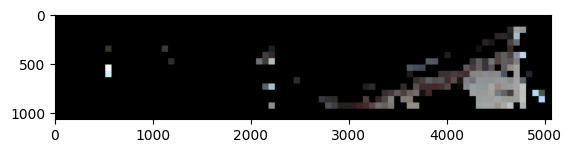

In [4]:
from matplotlib import pyplot as plt

plt.imshow(output_scene.detach().numpy().transpose(1, 0, 2))

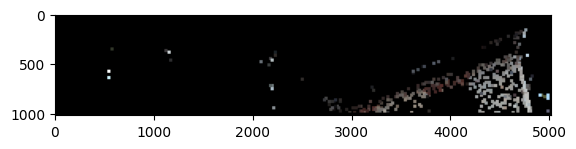

In [4]:
from matplotlib import pyplot as plt

plt.imshow(output_scene.detach().numpy().transpose(1, 0, 2))

In [10]:
output_scene.shape

torch.Size([5016, 1016, 3])

In [ ]:
truth = points

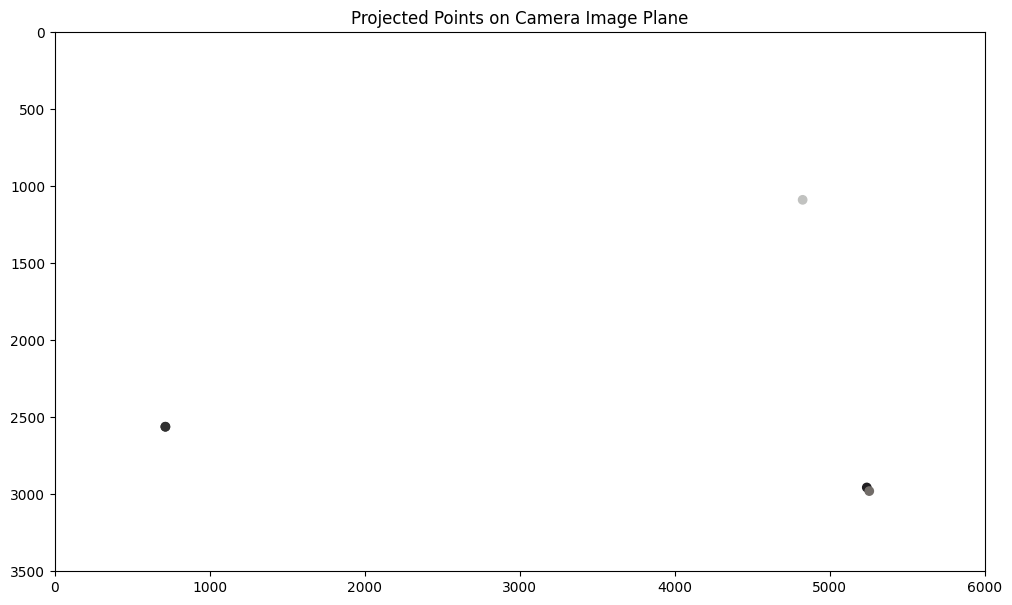

In [50]:
import numpy as np
import matplotlib.pyplot as plt
points2d = np.array(points.cpu().detach())
colors2d = np.array(scene.colors.cpu().detach())

# Plot points
plt.figure(figsize=(12, 7))
plt.scatter(points2d[:, 0], points2d[:, 1], c=colors2d[:5])
plt.xlim(0, 6000)
plt.ylim(0, 3500)
plt.gca().invert_yaxis()  # Invert the y-axis to match the image coordinates
plt.title('Projected Points on Camera Image Plane')
plt.show()
